In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
    LocalizedFCReadIn,
)

from data_utils import (
    get_mouse_v1_data,
    append_syn_dataloaders,
    append_data_aug_dataloaders,
    RespGaussianNoise,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    # "crop_win": None,
    # "crop_win": (slice(7, 29), slice(15, 51)),
    "crop_win": (22, 36),
    # "wandb": None,
    "wandb": {
        "project": "CSNG",
        "group": "sensorium_2022",
    },
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 16,
        "batch_size": 4,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
})

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config)

Training dataset:	 22416 samples
Validation dataset:	 2516 samples
Test dataset:		 4984 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([4, 1, 36, 64])
  min=-1.699  max=2.123
  mean=0.075  std=0.925
responses:
  torch.Size([4, 8372])
  min=-0.000  max=21.945
  mean=0.313  std=0.986
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


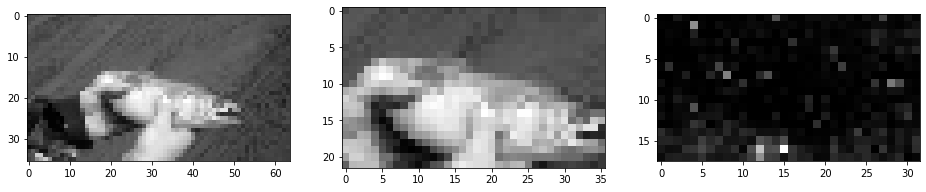

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["val"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None, # the same data key as the original (real) data
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
syn_sample_data_key = dataloaders["mouse_v1"]["train"].data_keys[-1]
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[syn_sample_data_key]
H, W = syn_stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = syn_resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Data augmentation

In [8]:
config["data"]["data_augmentation"] = {
    "data_transforms": [RespGaussianNoise(0.1)],
    "append_data_parts": ["train"],
    "force_same_order": False,
    "seed": config["seed"],
}

In [9]:
dataloaders = append_data_aug_dataloaders(
    dataloaders=dataloaders,
    config=config["data"]["data_augmentation"],
)

## Encoder

In [10]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
    pickle_module=dill,
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

Loading encoder...


/home/jsobotka/miniconda3/envs/dev/lib/python3.10/site-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


## Decoder

In [11]:
def train(model, dataloader, opter, loss_fn, config, verbose=True):
    model.train()
    train_loss = 0
    n_batches = len(dataloader)

    ### run
    for batch_idx, b in enumerate(dataloader):
        opter.zero_grad()
        loss = 0

        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            ### get loss
            stim_pred = model(
                resp,
                data_key=data_key,
                neuron_coords=neuron_coords,
                pupil_center=pupil_center
            )
            loss += loss_fn(stim_pred, stim, data_key=data_key, phase="train", neuron_coords=neuron_coords, pupil_center=pupil_center)
            model.set_additional_loss(
                inp={
                    "resp": resp,
                    "stim": stim,
                    "neuron_coords": neuron_coords,
                    "pupil_center": pupil_center,
                    "data_key": data_key,
                }, out={
                    "stim_pred": stim_pred,
                },
            )
            loss += model.get_additional_loss(data_key=data_key)

        ### update
        loss /= len(b)
        loss.backward()
        opter.step()

        ### log
        train_loss += loss.item()
        if verbose and batch_idx % 100 == 0:
            print(f"Training progress: [{batch_idx}/{n_batches} ({100. * batch_idx / n_batches:.0f}%)]"
                  f"  Loss: {loss.item():.6f}")

    train_loss /= n_batches
    return train_loss

In [12]:
def val(model, dataloader, loss_fn, config, only_data_keys=None):
    model.eval()
    val_losses = {"total": 0}
    denom_data_keys = {}
    with torch.no_grad():
        for b in dataloader:
            ### combine from all data keys
            for data_key, stim, resp, neuron_coords, pupil_center in b:
                if only_data_keys is not None and data_key not in only_data_keys:
                    continue
                stim_pred = model(
                    resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )
                loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
                val_losses[data_key] = loss if data_key not in val_losses else val_losses[data_key] + loss
                val_losses["total"] += loss / len(b)
                denom_data_keys[data_key] = denom_data_keys[data_key] + 1 if data_key in denom_data_keys else 1

    val_losses["total"] /= len(dataloader)
    for k in denom_data_keys:
        val_losses[k] /= denom_data_keys[k]
    return val_losses

In [13]:
config["decoder"] = {
    "model": {
        "readins_config": [
            {
                "data_key": data_key,
                "in_shape": n_coords.shape[-2],
                "decoding_objective_config": None,
                # "decoding_objective_config": {
                #     "decoder_cls": FCReadIn,
                #     "decoder_config": {
                #         "in_shape": 68*9*16,
                #         "layers_config": [("fc", 264), ("fc", d.n_neurons),],
                #         "act_fn": nn.LeakyReLU,
                #         "out_act_fn": nn.Identity,
                #         "dropout": 0.0,
                #         "batch_norm": False,
                #     },
                #     "loss_fn": nn.MSELoss(),
                # },
                "layers": [
                    # ("fc", 432),
                    # ("unflatten", 1, (3, 9, 16)),

                    # (LocalizedFCReadIn, {
                    #     "in_shape": d.n_neurons,
                    #     "layers": [
                    #         {"n_bins": 20, "reduce_by": 3},
                    #         {"n_bins": 12, "reduce_by": 2},
                    #         {"n_bins": 7, "reduce_by": 2},
                    #         {"n_bins": 2, "reduce_by": 2},
                    #     ],
                    #     "out_config": {
                    #         "shape": (3, 9, 16),
                    #         "method": "linear",
                    #     },
                    #     "act_fn": nn.LeakyReLU,
                    #     "out_act_fn": nn.Identity,
                    #     "dropout": 0.15,
                    #     "batch_norm": True,
                    # }),

                    # (AttentionReadIn, {
                    #     "in_shape": d.n_neurons,
                    #     "shift_coords": True,
                    #     "shifter_net_layers": [
                    #         ("fc", 10),
                    #         ("fc", 10),
                    #         ("fc", 2),
                    #     ],
                    #     "shifter_net_act_fn": nn.LeakyReLU,
                    #     "shifter_net_out_act_fn": nn.Tanh,
                    #     "attn_config": {
                    #         "layers": 1,
                    #         "token_neurons": 20,
                    #         "dim_head": 256,
                    #         "dropout": 0.1,
                    #         "attn_num_heads": 1,
                    #     },
                    #     "attn_interleave_config": {
                    #         "layers": [
                    #             ("fc", 512),
                    #             ("act_fn", nn.ReLU),
                    #             ("dropout", 0.15),
                    #             ("fc", 256)
                    #         ],
                    #         "after_last": True,
                    #     },
                    #     "neuron_embed_dim": 16,
                    #     "conv_out_config": {
                    #         "out_channels": 64,
                    #         "kernel_size": 5,
                    #         "stride": 1,
                    #         "padding": 2,
                    #         "bias": False,
                    #         "batch_norm": True,
                    #         "act_fn": nn.LeakyReLU,
                    #     },
                    # }),

                    (ConvReadIn, {
                        "shift_coords": True,
                        "learn_grid": True,
                        "grid_l1_reg": 8e-3,
                        "in_channels_group_size": 1,
                        # "grid_net_config": {
                        #     "in_channels": 32, # x, y, z, resp
                        #     "layers_config": [("fc", 64), ("fc", 64), ("fc", 16*9)],
                        #     "act_fn": nn.LeakyReLU,
                        #     "out_act_fn": nn.Identity,
                        #     "dropout": 0.1,
                        #     "batch_norm": False,
                        # },
                        "pointwise_conv_config": {
                            "in_channels": n_coords.shape[-2],
                            "out_channels": 256,
                            "act_fn": nn.LeakyReLU,
                            "bias": False,
                            "batch_norm": True,
                        },
                        "gauss_blur": False,
                        "gauss_blur_kernel_size": 7,
                        "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                        # "gauss_blur_sigma": "per_neuron", # "fixed", "single", "per_neuron"
                        "gauss_blur_sigma_init": 1.5,
                        "neuron_emb_dim": None,
                    }),

                    # (FCReadIn, {
                    #     "in_shape": d.n_neurons,
                    #     "layers_config": [
                    #         ("fc", 432),
                    #         ("unflatten", 1, (3, 9, 16)),
                    #     ],
                    #     "act_fn": nn.LeakyReLU,
                    #     "out_act_fn": nn.Identity,
                    #     "batch_norm": True,
                    #     "dropout": 0.45,
                    #     "out_channels": 3,
                    # }),

                    # (AutoEncoderReadIn, {
                    #     "loss_mul": 1,
                    #     "encoder_config": {
                    #         "in_shape": d.n_neurons,
                    #         "layers_config": [
                    #             ("fc", 288),
                    #             ("unflatten", 1, (2, 9, 16)),
                    #         ],
                    #         "act_fn": nn.LeakyReLU,
                    #         "out_act_fn": nn.Identity,
                    #         "batch_norm": True,
                    #         "dropout": 0.2,
                    #         "out_channels": 2,
                    #     },
                    #     "decoder_config": {
                    #         "layers_config": [
                    #             ("fc", 312),
                    #             ("fc", d.n_neurons),
                    #         ],
                    #         "act_fn": nn.LeakyReLU,
                    #         "out_act_fn": nn.Identity,
                    #         "batch_norm": False,
                    #         "dropout": 0.1,
                    #     },
                    # }),

                    # (Conv1dReadIn, {
                    #     # "in_shape": d.n_neurons,
                    #     "in_shape": 1,
                    #     "out_channels": 2,
                    #     "layers_config": [
                    #         ("conv1d", 64, 7, 3, 3),
                    #         ("conv1d", 32, 7, 3, 3),
                    #         ("conv1d", 16, 5, 2, 2),
                    #         ("conv1d", 8, 4, 2, 1),
                    #         ("flatten", 1, -1, 1632),
                    #         ("fc", 288),
                    #         ("unflatten", 1, (2, 9, 16)),
                    #     ],
                    #     "act_fn": nn.ReLU,
                    #     "out_act_fn": nn.Identity,
                    #     "batch_norm": True,
                    #     "dropout": 0.15,
                    # }),

                    # (HypernetReadIn, {
                    #     "n_neurons": d.n_neurons,
                    #     "hypernet_layers": [
                    #         # ("fc", 40),
                    #         ("fc", 64),
                    #         ("fc", 64),
                    #         ("fc", 1152),
                    #     ],
                    #     "hypernet_act_fn": nn.LeakyReLU,
                    #     # "hypernet_act_fn": nn.Tanh,
                    #     "hypernet_out_act_fn": nn.Identity,
                    #     "hypernet_dropout": 0.,
                    #     "hypernet_batch_norm": False,
                    #     "hypernet_init": "normal",
                    #     "hypernet_init_kwargs": {
                    #         "mean": 0,
                    #         "std": 1/(d.n_neurons*1152),
                    #     },
                    #     "hypernet_neuron_embed_dim": 32,
                    #     "target_in_shape": d.n_neurons,
                    #     "target_layers": [
                    #         ("fc", 1152),
                    #         ("unflatten", 1, (8, 9, 16)),
                    #     ],
                    #     # "target_act_fn": nn.LeakyReLU,
                    #     "target_act_fn": nn.Identity,
                    #     "target_out_act_fn": nn.Identity,
                    #     "target_dropout": 0.15,
                    #     "target_out_layer_norm": True,
                    #     "shift_coords": True,
                    #     "shifter_net_layers": [
                    #         ("fc", 10),
                    #         ("fc", 10),
                    #         ("fc", 2),
                    #     ],
                    #     "shifter_net_act_fn": nn.LeakyReLU,
                    #     "shifter_net_out_act_fn": nn.Tanh,
                    # }),

                ],
            # } for d, data_key in zip(dataloaders["mouse_v1"]["train"].datasets, dataloaders["mouse_v1"]["train"].data_keys)
            } for data_key, n_coords in dataloaders["mouse_v1"]["train"].neuron_coords.items()
        ],
        "core_cls": CNN_Decoder,
        "core_config": {
            "resp_shape": [256],
            "stim_shape": list(stim.shape[1:]),
            "layers": [
                ### for conv_readin
                ("deconv", 256, 7, 2, 2),
                # ("deconv", 128, 7, 2, 1),
                # ("deconv", 64, 5, 2, 2),
                
                ("deconv", 128, 5, 1, 2),
                # ("deconv", 64, 5, 1, 1),

                ("deconv", 64, 5, 1, 2),
                # ("deconv", 32, 4, 1, 1),

                ("deconv", 64, 4, 1, 1),
                # ("deconv", 32, 4, 1, 1),

                # ("deconv", 64, 4, 1, 1),
                ("deconv", 32, 3, 1, 1),

                ("deconv", 1, 3, 1, 0),


                ### for attn_readin
                # ("deconv", 64, 7, 2, 3),
                # ("deconv", 32, 4, 1, 2),
                # ("deconv", 1, 3, 1, 0),
            ],
            "act_fn": nn.ReLU,
            "out_act_fn": nn.Identity,
            "dropout": 0.3,
            "batch_norm": True,
        },
    },
    "opter_cls": torch.optim.Adam,
    "opter_kwargs": {
        "lr": 3e-4,
    },
    "loss": {
        # "loss_fn": MSELossWithCrop(window=config["crop_win"], standardize=False),
        "loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        "l1_reg_mul": 0,
        "l2_reg_mul": 1e-5,
        # "con_reg_mul": 0,
        "con_reg_mul": 1,
        "con_reg_loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        # "encoder": None,
        "encoder": encoder,
    },
    "n_epochs": 200,
    "load_ckpt": None,
    # "load_ckpt": {
    #     # "load_only_core": False,
    #     "load_only_core": True,
    #     "ckpt_path": os.path.join(
    #         DATA_PATH, "models", "cat_v1_pretraining", "2024-02-27_19-17-39", "decoder.pt"),
    #         # DATA_PATH, "models", "cnn", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    # },
    "save_run": True,
}

[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.
[WARNING] Setting nonnegative_ssim to True as log_loss is set to True.


In [14]:
### initialize (and load ckpt if needed)
if config["decoder"]["load_ckpt"] != None:
    print(f"[INFO] Loading checkpoint from {config['decoder']['load_ckpt']['ckpt_path']}...")
    ckpt = torch.load(config["decoder"]["load_ckpt"]["ckpt_path"], map_location=config["device"], pickle_module=dill)

    if config["decoder"]["load_ckpt"]["load_only_core"]:
        print("[INFO] Loading only the core of the model (no history, no best ckpt)...")

        ### init decoder (load only the core)
        config["decoder"]["model"]["core_cls"] = ckpt["config"]["decoder"]["model"]["core_cls"]
        config["decoder"]["model"]["core_config"] = ckpt["config"]["decoder"]["model"]["core_config"]
        decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
        decoder.load_state_dict({k:v for k,v in ckpt["best"]["model"].items() if "readin" not in k}, strict=False)

        ### init the rest
        opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
        loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
        history = {"train_loss": [], "val_loss": []}
        best = {"val_loss": np.inf, "epoch": 0, "model": None}
    else:
        print("[INFO] Loading the whole model (the latest - not the BEST; with history and best ckpt)...")
        history, config["decoder"]["model"], best = ckpt["history"], ckpt["config"]["decoder"]["model"], ckpt["best"]

        decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
        decoder.load_state_dict(ckpt["decoder"])

        opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
        opter.load_state_dict(ckpt["opter"])
        loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
else:
    print("[INFO] Initializing the model from scratch...")
    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
    loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
    
    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}

[INFO] Initializing the model from scratch...
[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 256)


In [15]:
### print model and fix sizes of stimuli
with torch.no_grad():
    stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
    if stim_pred.shape != crop(stim, config["crop_win"]).shape:
        print(f"[WARNING] Stimulus prediction shape {stim_pred.shape} does not match stimulus shape {crop(stim, config['crop_win']).shape}.")
        assert stim_pred.shape[-2] >= crop(stim, config["crop_win"]).shape[-2] \
            and stim_pred.shape[-1] >= crop(stim, config["crop_win"]).shape[-1]
        
        # ### set crop function
        # decoder.crop_stim_fn = lambda x: x[:, :, :crop(stim, config["crop_win"]).shape[-2], :crop(stim, config["crop_win"]).shape[-1]]
        # stim_pred = decoder(resp.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_data_key], pupil_center=pupil_center.to(config["device"]))
        # print(f"[INFO] Stimulus prediction shape cropped to {stim_pred.shape}.")

    print(stim_pred.shape)
    del stim_pred

print(
    f"Number of parameters:"
    f"\n  whole model: {count_parameters(decoder)}"
    f"\n  core: {count_parameters(decoder.core)} ({count_parameters(decoder.core) / count_parameters(decoder) * 100:.2f}%)"
    f"\n  readins: {count_parameters(decoder.readins)} ({count_parameters(decoder.readins) / count_parameters(decoder) * 100:.2f}%)"
    f"\n    ({', '.join([f'{k}: {count_parameters(v)} [{count_parameters(v) / count_parameters(decoder) * 100:.2f}%]' for k, v in decoder.readins.items()])})"
)

decoder

torch.Size([4, 1, 22, 36])
Number of parameters:
  whole model: 14431963
  core: 4321153 (29.94%)
  readins: 10110810 (70.06%)
    (21067-10-18: 2155538 [14.94%], 22846-10-16: 1892370 [13.11%], 23343-5-17: 1889810 [13.09%], 23656-14-22: 2087698 [14.47%], 23964-4-22: 2085394 [14.45%])


MultiReadIn(
  (readins): ModuleDict(
    (21067-10-18): ModuleList(
      (0): ConvReadIn(
        (shifter_net): ShifterNet(
          (layers): Sequential(
            (0): Linear(in_features=2, out_features=10, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=10, out_features=10, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=10, out_features=2, bias=True)
            (5): Tanh()
          )
        )
        (pointwise_conv): Sequential(
          (0): Identity()
          (1): Conv2d(8372, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.01)
        )
        (grid_net): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Dropout(p=0.1, inplace=False)
          (3)

In [16]:
### prepare checkpointing and wandb logging
config["run_name"] = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
if config["decoder"]["save_run"]:
    ### save config
    config["dir"] = os.path.join(DATA_PATH, "models", "cnn", config["run_name"])
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {config['run_name']}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("[WARNING] Not saving the run and the config.")

if config["wandb"]:
    wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config,
        tags=[
            config["decoder"]["model"]["core_cls"].__name__,
            config["decoder"]["model"]["readins_config"][0]["layers"][0][0].__name__,
            # "contrastive_regularization",
            # "cat_v1_pretraining"
        ],
        notes=None)
    wdb_run.watch(decoder)
else:
    print("[WARNING] Not using wandb.")

Run name: 2024-03-03_21-37-06
Run dir: /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06


[1/200]
Training progress: [0/6721 (0%)]  Loss: 7.762242
Training progress: [100/6721 (1%)]  Loss: 2.934848
Training progress: [200/6721 (3%)]  Loss: 3.150909
Training progress: [300/6721 (4%)]  Loss: 2.716007
Training progress: [400/6721 (6%)]  Loss: 2.475862
Training progress: [500/6721 (7%)]  Loss: 2.593374
Training progress: [600/6721 (9%)]  Loss: 2.578241
Training progress: [700/6721 (10%)]  Loss: 2.447354
Training progress: [800/6721 (12%)]  Loss: 2.764127
Training progress: [900/6721 (13%)]  Loss: 2.320126
Training progress: [1000/6721 (15%)]  Loss: 2.254462
Training progress: [1100/6721 (16%)]  Loss: 2.476845
train_loss=0.4596, val_losses['total']=2.4445, 21067-10-18: 2.5606, 22846-10-16: 2.3726, 23343-5-17: 2.3876, 23656-14-22: 2.4285, 23964-4-22: 2.3753


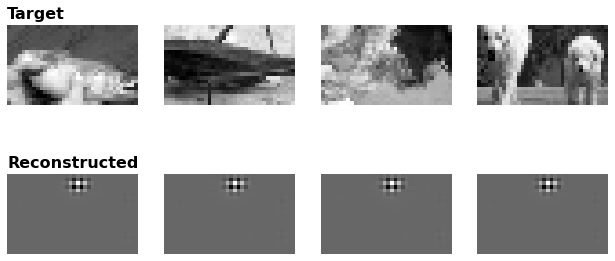

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_0e.png.
[2/200]
Training progress: [0/6721 (0%)]  Loss: 2.432903
Training progress: [100/6721 (1%)]  Loss: 2.494008
Training progress: [200/6721 (3%)]  Loss: 2.782822
Training progress: [300/6721 (4%)]  Loss: 2.474656
Training progress: [400/6721 (6%)]  Loss: 2.241454
Training progress: [500/6721 (7%)]  Loss: 2.415418
Training progress: [600/6721 (9%)]  Loss: 2.421684
Training progress: [700/6721 (10%)]  Loss: 2.315695
Training progress: [800/6721 (12%)]  Loss: 2.620521
Training progress: [900/6721 (13%)]  Loss: 2.237520
Training progress: [1000/6721 (15%)]  Loss: 2.197698
Training progress: [1100/6721 (16%)]  Loss: 2.420909
train_loss=0.4125, val_losses['total']=2.4229, 21067-10-18: 2.5328, 22846-10-16: 2.3687, 23343-5-17: 2.3767, 23656-14-22: 2.3877, 23964-4-22: 2.3512


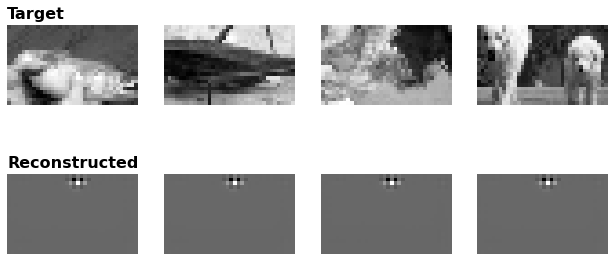

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_1e.png.
[3/200]
Training progress: [0/6721 (0%)]  Loss: 2.375866
Training progress: [100/6721 (1%)]  Loss: 2.440371
Training progress: [200/6721 (3%)]  Loss: 2.754003
Training progress: [300/6721 (4%)]  Loss: 2.432495
Training progress: [400/6721 (6%)]  Loss: 2.204019
Training progress: [500/6721 (7%)]  Loss: 2.390314
Training progress: [600/6721 (9%)]  Loss: 2.391334
Training progress: [700/6721 (10%)]  Loss: 2.296549
Training progress: [800/6721 (12%)]  Loss: 2.597617
Training progress: [900/6721 (13%)]  Loss: 2.217715
Training progress: [1000/6721 (15%)]  Loss: 2.179556
Training progress: [1100/6721 (16%)]  Loss: 2.394509
train_loss=0.4073, val_losses['total']=2.4186, 21067-10-18: 2.5304, 22846-10-16: 2.3665, 23343-5-17: 2.3736, 23656-14-22: 2.3785, 23964-4-22: 2.3471


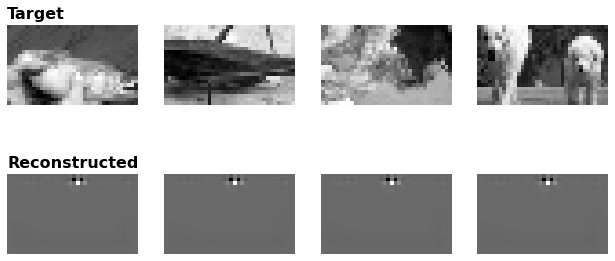

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_2e.png.
[4/200]
Training progress: [0/6721 (0%)]  Loss: 2.363266
Training progress: [100/6721 (1%)]  Loss: 2.408009
Training progress: [200/6721 (3%)]  Loss: 2.720839
Training progress: [300/6721 (4%)]  Loss: 2.400512
Training progress: [400/6721 (6%)]  Loss: 2.150630
Training progress: [500/6721 (7%)]  Loss: 2.335212
Training progress: [600/6721 (9%)]  Loss: 2.328004
Training progress: [700/6721 (10%)]  Loss: 2.211753
Training progress: [800/6721 (12%)]  Loss: 2.090936
Training progress: [900/6721 (13%)]  Loss: 1.920428
Training progress: [1000/6721 (15%)]  Loss: 1.826739
Training progress: [1100/6721 (16%)]  Loss: 1.905158
train_loss=0.3766, val_losses['total']=1.6702, 21067-10-18: 1.8608, 22846-10-16: 1.6984, 23343-5-17: 1.6976, 23656-14-22: 1.4216, 23964-4-22: 1.6044


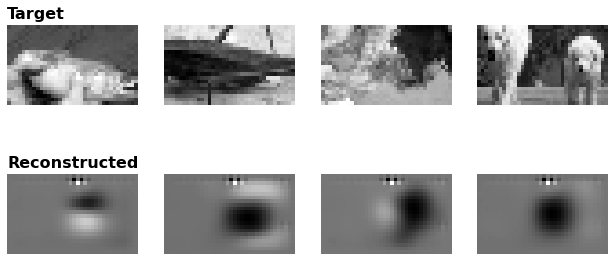

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_3e.png.
[5/200]
Training progress: [0/6721 (0%)]  Loss: 1.990602
Training progress: [100/6721 (1%)]  Loss: 1.867050
Training progress: [200/6721 (3%)]  Loss: 1.789272
Training progress: [300/6721 (4%)]  Loss: 1.785642
Training progress: [400/6721 (6%)]  Loss: 1.629188
Training progress: [500/6721 (7%)]  Loss: 1.688919
Training progress: [600/6721 (9%)]  Loss: 1.584503
Training progress: [700/6721 (10%)]  Loss: 1.571169
Training progress: [800/6721 (12%)]  Loss: 1.572500
Training progress: [900/6721 (13%)]  Loss: 1.458115
Training progress: [1000/6721 (15%)]  Loss: 1.397800
Training progress: [1100/6721 (16%)]  Loss: 1.515543
train_loss=0.2769, val_losses['total']=1.3930, 21067-10-18: 1.5789, 22846-10-16: 1.3898, 23343-5-17: 1.3896, 23656-14-22: 1.2134, 23964-4-22: 1.3350


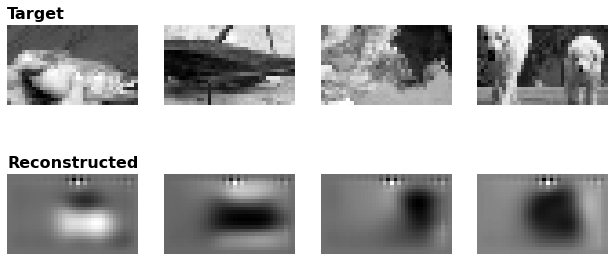

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_4e.png.
[6/200]
Training progress: [0/6721 (0%)]  Loss: 1.522270
Training progress: [100/6721 (1%)]  Loss: 1.454798
Training progress: [200/6721 (3%)]  Loss: 1.441696
Training progress: [300/6721 (4%)]  Loss: 1.391098
Training progress: [400/6721 (6%)]  Loss: 1.312626
Training progress: [500/6721 (7%)]  Loss: 1.366480
Training progress: [600/6721 (9%)]  Loss: 1.310901
Training progress: [700/6721 (10%)]  Loss: 1.298051
Training progress: [800/6721 (12%)]  Loss: 1.311897
Training progress: [900/6721 (13%)]  Loss: 1.205708
Training progress: [1000/6721 (15%)]  Loss: 1.186487
Training progress: [1100/6721 (16%)]  Loss: 1.274102
train_loss=0.2247, val_losses['total']=1.2812, 21067-10-18: 1.4094, 22846-10-16: 1.2756, 23343-5-17: 1.2865, 23656-14-22: 1.1438, 23964-4-22: 1.2379


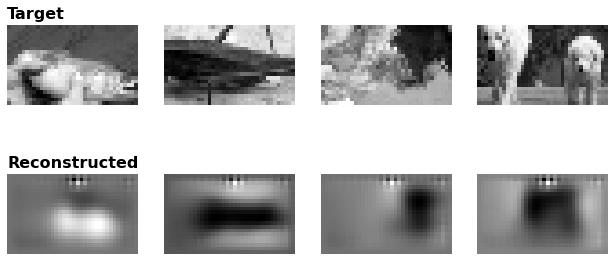

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_5e.png.


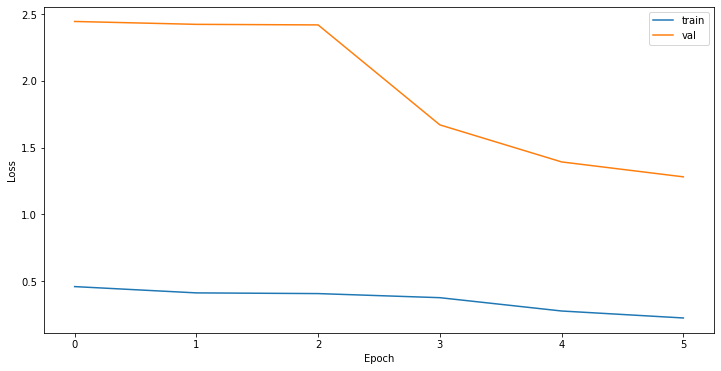

[7/200]
Training progress: [0/6721 (0%)]  Loss: 1.274234
Training progress: [100/6721 (1%)]  Loss: 1.278537
Training progress: [200/6721 (3%)]  Loss: 1.209329
Training progress: [300/6721 (4%)]  Loss: 1.179127
Training progress: [400/6721 (6%)]  Loss: 1.110617
Training progress: [500/6721 (7%)]  Loss: 1.165644
Training progress: [600/6721 (9%)]  Loss: 1.118569
Training progress: [700/6721 (10%)]  Loss: 1.140748
Training progress: [800/6721 (12%)]  Loss: 1.137041
Training progress: [900/6721 (13%)]  Loss: 1.052699
Training progress: [1000/6721 (15%)]  Loss: 1.025467
Training progress: [1100/6721 (16%)]  Loss: 1.119605
train_loss=0.1935, val_losses['total']=1.2227, 21067-10-18: 1.3309, 22846-10-16: 1.2041, 23343-5-17: 1.2343, 23656-14-22: 1.0961, 23964-4-22: 1.1980


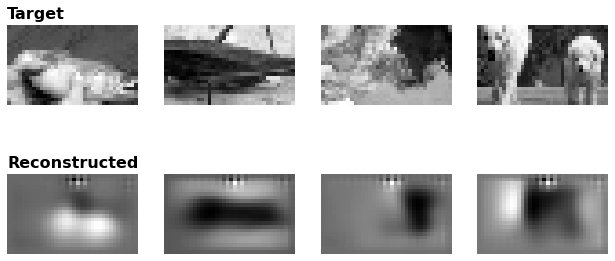

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_6e.png.
[8/200]
Training progress: [0/6721 (0%)]  Loss: 1.128127
Training progress: [100/6721 (1%)]  Loss: 1.141175
Training progress: [200/6721 (3%)]  Loss: 1.087241
Training progress: [300/6721 (4%)]  Loss: 1.055197
Training progress: [400/6721 (6%)]  Loss: 0.971003
Training progress: [500/6721 (7%)]  Loss: 1.036131
Training progress: [600/6721 (9%)]  Loss: 1.012413
Training progress: [700/6721 (10%)]  Loss: 1.029510
Training progress: [800/6721 (12%)]  Loss: 1.009532
Training progress: [900/6721 (13%)]  Loss: 0.949475
Training progress: [1000/6721 (15%)]  Loss: 0.927172
Training progress: [1100/6721 (16%)]  Loss: 1.020179
train_loss=0.1740, val_losses['total']=1.1925, 21067-10-18: 1.2907, 22846-10-16: 1.1681, 23343-5-17: 1.2083, 23656-14-22: 1.0769, 23964-4-22: 1.1690


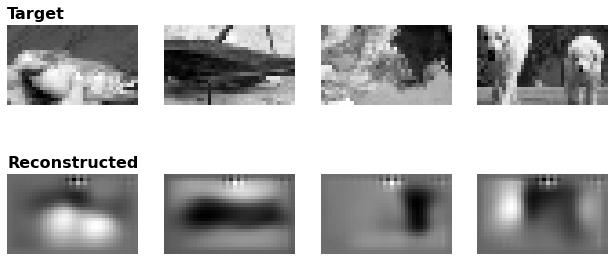

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_7e.png.
[9/200]
Training progress: [0/6721 (0%)]  Loss: 1.042103
Training progress: [100/6721 (1%)]  Loss: 1.046350
Training progress: [200/6721 (3%)]  Loss: 0.992711
Training progress: [300/6721 (4%)]  Loss: 0.942695
Training progress: [400/6721 (6%)]  Loss: 0.887621
Training progress: [500/6721 (7%)]  Loss: 0.963819
Training progress: [600/6721 (9%)]  Loss: 0.952274
Training progress: [700/6721 (10%)]  Loss: 0.973468
Training progress: [800/6721 (12%)]  Loss: 0.923279
Training progress: [900/6721 (13%)]  Loss: 0.891684
Training progress: [1000/6721 (15%)]  Loss: 0.855340
Training progress: [1100/6721 (16%)]  Loss: 0.939391
train_loss=0.1606, val_losses['total']=1.1729, 21067-10-18: 1.2539, 22846-10-16: 1.1477, 23343-5-17: 1.1948, 23656-14-22: 1.0570, 23964-4-22: 1.1635


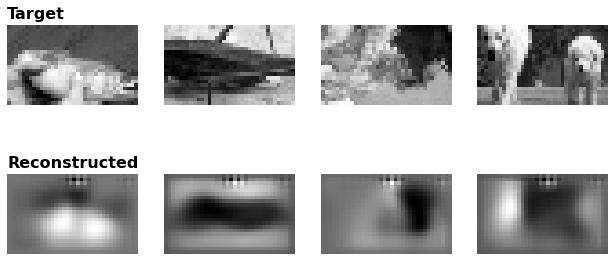

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_8e.png.
[10/200]
Training progress: [0/6721 (0%)]  Loss: 0.948155
Training progress: [100/6721 (1%)]  Loss: 0.986108
Training progress: [200/6721 (3%)]  Loss: 0.916963
Training progress: [300/6721 (4%)]  Loss: 0.893437
Training progress: [400/6721 (6%)]  Loss: 0.842706
Training progress: [500/6721 (7%)]  Loss: 0.902204
Training progress: [600/6721 (9%)]  Loss: 0.899531
Training progress: [700/6721 (10%)]  Loss: 0.898830
Training progress: [800/6721 (12%)]  Loss: 0.867530
Training progress: [900/6721 (13%)]  Loss: 0.827564
Training progress: [1000/6721 (15%)]  Loss: 0.825619
Training progress: [1100/6721 (16%)]  Loss: 0.895869
train_loss=0.1504, val_losses['total']=1.1561, 21067-10-18: 1.2401, 22846-10-16: 1.1380, 23343-5-17: 1.1754, 23656-14-22: 1.0413, 23964-4-22: 1.1388


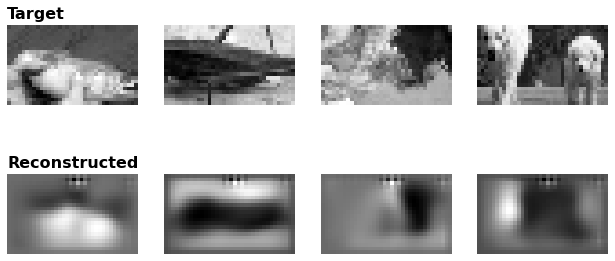

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_9e.png.
[11/200]
Training progress: [0/6721 (0%)]  Loss: 0.883359
Training progress: [100/6721 (1%)]  Loss: 0.947999
Training progress: [200/6721 (3%)]  Loss: 0.869073
Training progress: [300/6721 (4%)]  Loss: 0.836667
Training progress: [400/6721 (6%)]  Loss: 0.785219
Training progress: [500/6721 (7%)]  Loss: 0.835990
Training progress: [600/6721 (9%)]  Loss: 0.851090
Training progress: [700/6721 (10%)]  Loss: 0.867974
Training progress: [800/6721 (12%)]  Loss: 0.812072
Training progress: [900/6721 (13%)]  Loss: 0.773361
Training progress: [1000/6721 (15%)]  Loss: 0.773742
Training progress: [1100/6721 (16%)]  Loss: 0.848860
train_loss=0.1424, val_losses['total']=1.1475, 21067-10-18: 1.2236, 22846-10-16: 1.1234, 23343-5-17: 1.1714, 23656-14-22: 1.0334, 23964-4-22: 1.1387


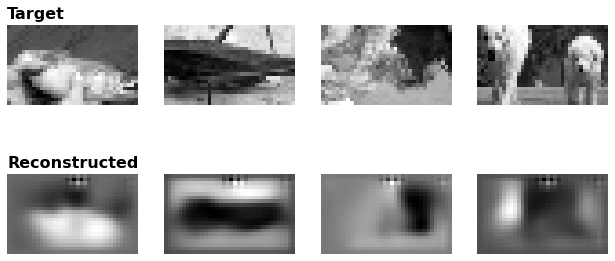

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_10e.png.


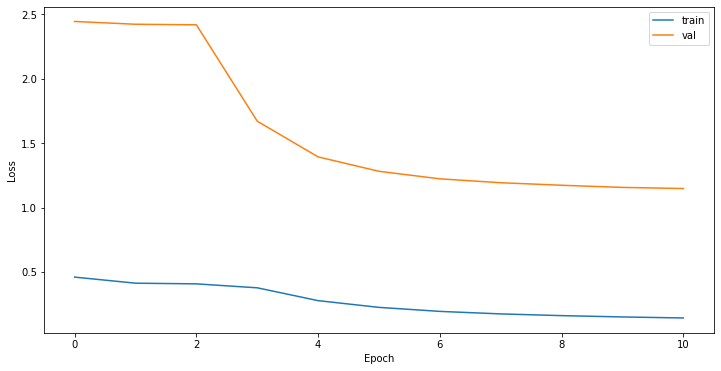

[12/200]
Training progress: [0/6721 (0%)]  Loss: 0.842280
Training progress: [100/6721 (1%)]  Loss: 0.901472
Training progress: [200/6721 (3%)]  Loss: 0.827807
Training progress: [300/6721 (4%)]  Loss: 0.804052
Training progress: [400/6721 (6%)]  Loss: 0.738089
Training progress: [500/6721 (7%)]  Loss: 0.800848
Training progress: [600/6721 (9%)]  Loss: 0.815554
Training progress: [700/6721 (10%)]  Loss: 0.804019
Training progress: [800/6721 (12%)]  Loss: 0.778719
Training progress: [900/6721 (13%)]  Loss: 0.750516
Training progress: [1000/6721 (15%)]  Loss: 0.751822
Training progress: [1100/6721 (16%)]  Loss: 0.796282
train_loss=0.1357, val_losses['total']=1.1407, 21067-10-18: 1.2144, 22846-10-16: 1.1060, 23343-5-17: 1.1679, 23656-14-22: 1.0306, 23964-4-22: 1.1373


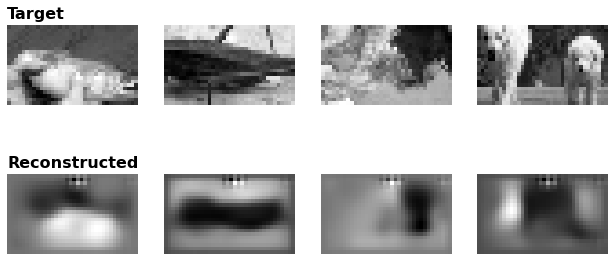

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_11e.png.
[13/200]
Training progress: [0/6721 (0%)]  Loss: 0.802131
Training progress: [100/6721 (1%)]  Loss: 0.854286
Training progress: [200/6721 (3%)]  Loss: 0.774980
Training progress: [300/6721 (4%)]  Loss: 0.761610
Training progress: [400/6721 (6%)]  Loss: 0.720611
Training progress: [500/6721 (7%)]  Loss: 0.776502
Training progress: [600/6721 (9%)]  Loss: 0.780935
Training progress: [700/6721 (10%)]  Loss: 0.777331
Training progress: [800/6721 (12%)]  Loss: 0.745393
Training progress: [900/6721 (13%)]  Loss: 0.711214
Training progress: [1000/6721 (15%)]  Loss: 0.729983
Training progress: [1100/6721 (16%)]  Loss: 0.769880
train_loss=0.1300, val_losses['total']=1.1370, 21067-10-18: 1.2013, 22846-10-16: 1.1069, 23343-5-17: 1.1664, 23656-14-22: 1.0260, 23964-4-22: 1.1373


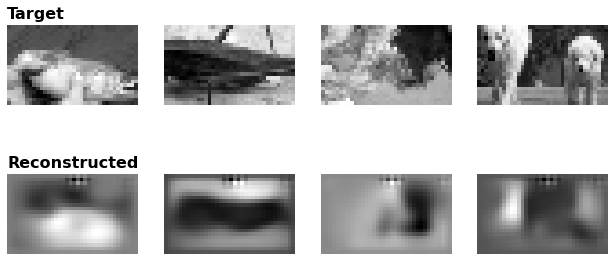

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_12e.png.
[14/200]
Training progress: [0/6721 (0%)]  Loss: 0.766694
Training progress: [100/6721 (1%)]  Loss: 0.829424
Training progress: [200/6721 (3%)]  Loss: 0.764735
Training progress: [300/6721 (4%)]  Loss: 0.729420
Training progress: [400/6721 (6%)]  Loss: 0.681188
Training progress: [500/6721 (7%)]  Loss: 0.742698
Training progress: [600/6721 (9%)]  Loss: 0.754595
Training progress: [700/6721 (10%)]  Loss: 0.748533
Training progress: [800/6721 (12%)]  Loss: 0.736083
Training progress: [900/6721 (13%)]  Loss: 0.693626
Training progress: [1000/6721 (15%)]  Loss: 0.695950
Training progress: [1100/6721 (16%)]  Loss: 0.727600
train_loss=0.1251, val_losses['total']=1.1383, 21067-10-18: 1.1963, 22846-10-16: 1.1091, 23343-5-17: 1.1648, 23656-14-22: 1.0269, 23964-4-22: 1.1471


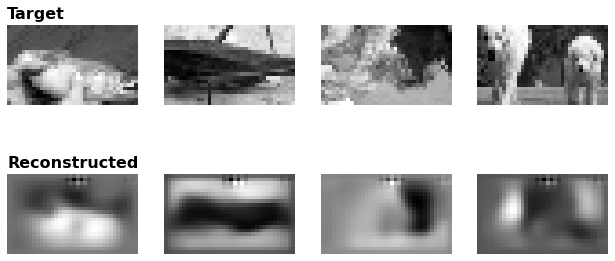

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_13e.png.
[15/200]
Training progress: [0/6721 (0%)]  Loss: 0.749925
Training progress: [100/6721 (1%)]  Loss: 0.792255
Training progress: [200/6721 (3%)]  Loss: 0.722198
Training progress: [300/6721 (4%)]  Loss: 0.705926
Training progress: [400/6721 (6%)]  Loss: 0.663577
Training progress: [500/6721 (7%)]  Loss: 0.720221
Training progress: [600/6721 (9%)]  Loss: 0.724531
Training progress: [700/6721 (10%)]  Loss: 0.720245
Training progress: [800/6721 (12%)]  Loss: 0.705863
Training progress: [900/6721 (13%)]  Loss: 0.674683
Training progress: [1000/6721 (15%)]  Loss: 0.672488
Training progress: [1100/6721 (16%)]  Loss: 0.719146
train_loss=0.1207, val_losses['total']=1.1382, 21067-10-18: 1.2040, 22846-10-16: 1.1067, 23343-5-17: 1.1578, 23656-14-22: 1.0332, 23964-4-22: 1.1423


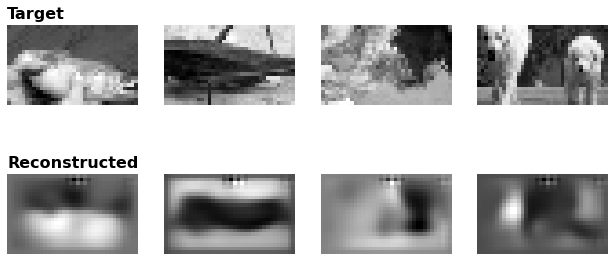

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_14e.png.
[16/200]
Training progress: [0/6721 (0%)]  Loss: 0.730224
Training progress: [100/6721 (1%)]  Loss: 0.774937
Training progress: [200/6721 (3%)]  Loss: 0.711659
Training progress: [300/6721 (4%)]  Loss: 0.680125
Training progress: [400/6721 (6%)]  Loss: 0.635877
Training progress: [500/6721 (7%)]  Loss: 0.689149
Training progress: [600/6721 (9%)]  Loss: 0.700420
Training progress: [700/6721 (10%)]  Loss: 0.700858
Training progress: [800/6721 (12%)]  Loss: 0.682869
Training progress: [900/6721 (13%)]  Loss: 0.640539
Training progress: [1000/6721 (15%)]  Loss: 0.648878
Training progress: [1100/6721 (16%)]  Loss: 0.691639
train_loss=0.1171, val_losses['total']=1.1306, 21067-10-18: 1.1911, 22846-10-16: 1.0990, 23343-5-17: 1.1516, 23656-14-22: 1.0248, 23964-4-22: 1.1402


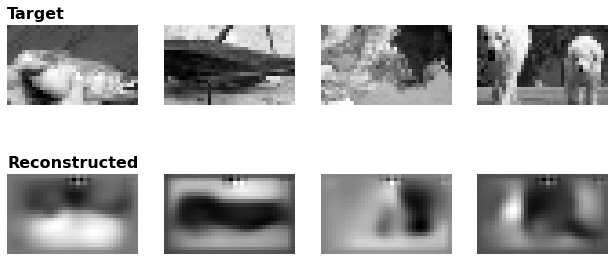

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_15e.png.


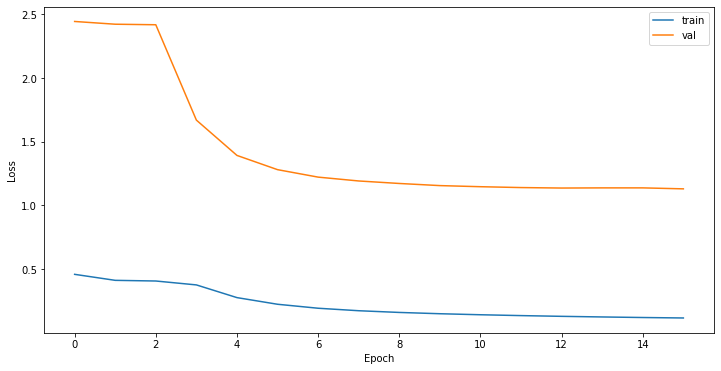

[17/200]
Training progress: [0/6721 (0%)]  Loss: 0.704617
Training progress: [100/6721 (1%)]  Loss: 0.748937
Training progress: [200/6721 (3%)]  Loss: 0.686245
Training progress: [300/6721 (4%)]  Loss: 0.659091
Training progress: [400/6721 (6%)]  Loss: 0.619975
Training progress: [500/6721 (7%)]  Loss: 0.670820
Training progress: [600/6721 (9%)]  Loss: 0.687147
Training progress: [700/6721 (10%)]  Loss: 0.693331
Training progress: [800/6721 (12%)]  Loss: 0.670183
Training progress: [900/6721 (13%)]  Loss: 0.648915
Training progress: [1000/6721 (15%)]  Loss: 0.636414
Training progress: [1100/6721 (16%)]  Loss: 0.667038
train_loss=0.1138, val_losses['total']=1.1305, 21067-10-18: 1.1927, 22846-10-16: 1.0997, 23343-5-17: 1.1519, 23656-14-22: 1.0216, 23964-4-22: 1.1397


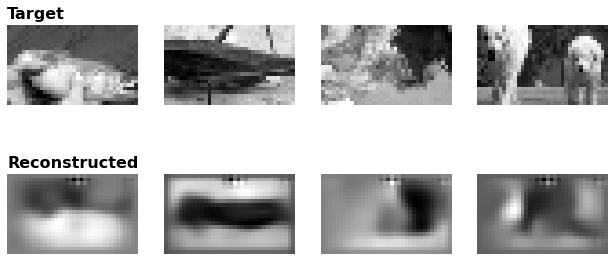

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_16e.png.
[18/200]
Training progress: [0/6721 (0%)]  Loss: 0.684302
Training progress: [100/6721 (1%)]  Loss: 0.732174
Training progress: [200/6721 (3%)]  Loss: 0.653396
Training progress: [300/6721 (4%)]  Loss: 0.635896
Training progress: [400/6721 (6%)]  Loss: 0.600362
Training progress: [500/6721 (7%)]  Loss: 0.652849
Training progress: [600/6721 (9%)]  Loss: 0.674950
Training progress: [700/6721 (10%)]  Loss: 0.667777
Training progress: [800/6721 (12%)]  Loss: 0.643813
Training progress: [900/6721 (13%)]  Loss: 0.628521
Training progress: [1000/6721 (15%)]  Loss: 0.611462
Training progress: [1100/6721 (16%)]  Loss: 0.651601
train_loss=0.1108, val_losses['total']=1.1279, 21067-10-18: 1.1860, 22846-10-16: 1.0938, 23343-5-17: 1.1545, 23656-14-22: 1.0221, 23964-4-22: 1.1366


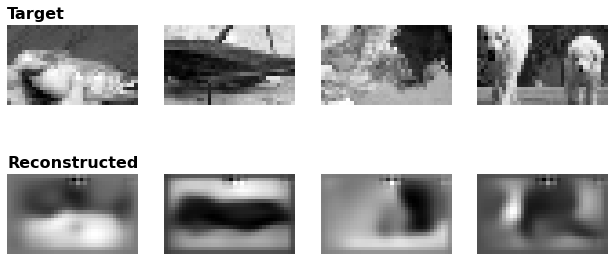

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_17e.png.
[19/200]
Training progress: [0/6721 (0%)]  Loss: 0.674164
Training progress: [100/6721 (1%)]  Loss: 0.713703
Training progress: [200/6721 (3%)]  Loss: 0.636132
Training progress: [300/6721 (4%)]  Loss: 0.624738
Training progress: [400/6721 (6%)]  Loss: 0.590075
Training progress: [500/6721 (7%)]  Loss: 0.635312
Training progress: [600/6721 (9%)]  Loss: 0.649737
Training progress: [700/6721 (10%)]  Loss: 0.641862
Training progress: [800/6721 (12%)]  Loss: 0.631477
Training progress: [900/6721 (13%)]  Loss: 0.605473
Training progress: [1000/6721 (15%)]  Loss: 0.591057
Training progress: [1100/6721 (16%)]  Loss: 0.649086
train_loss=0.1080, val_losses['total']=1.1290, 21067-10-18: 1.1823, 22846-10-16: 1.1012, 23343-5-17: 1.1515, 23656-14-22: 1.0255, 23964-4-22: 1.1377


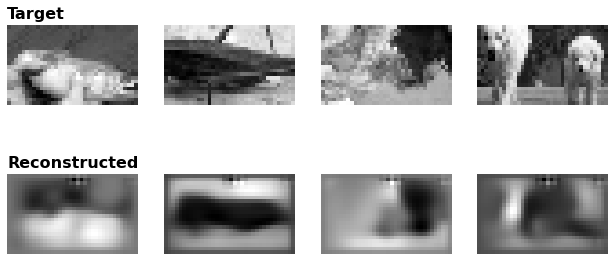

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_18e.png.
[20/200]
Training progress: [0/6721 (0%)]  Loss: 0.666732
Training progress: [100/6721 (1%)]  Loss: 0.686949
Training progress: [200/6721 (3%)]  Loss: 0.622961
Training progress: [300/6721 (4%)]  Loss: 0.611667
Training progress: [400/6721 (6%)]  Loss: 0.573548
Training progress: [500/6721 (7%)]  Loss: 0.621488
Training progress: [600/6721 (9%)]  Loss: 0.637744
Training progress: [700/6721 (10%)]  Loss: 0.636138
Training progress: [800/6721 (12%)]  Loss: 0.612405
Training progress: [900/6721 (13%)]  Loss: 0.589404
Training progress: [1000/6721 (15%)]  Loss: 0.585383
Training progress: [1100/6721 (16%)]  Loss: 0.635323
train_loss=0.1056, val_losses['total']=1.1285, 21067-10-18: 1.1834, 22846-10-16: 1.0949, 23343-5-17: 1.1566, 23656-14-22: 1.0267, 23964-4-22: 1.1343


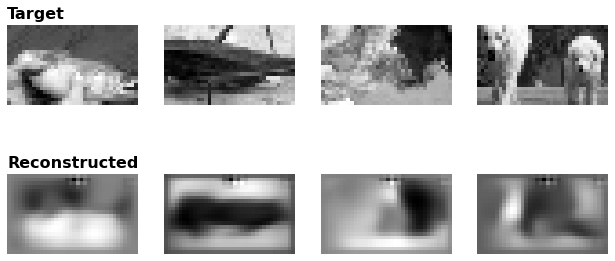

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_19e.png.
[21/200]
Training progress: [0/6721 (0%)]  Loss: 0.641949
Training progress: [100/6721 (1%)]  Loss: 0.669974
Training progress: [200/6721 (3%)]  Loss: 0.609985
Training progress: [300/6721 (4%)]  Loss: 0.595808
Training progress: [400/6721 (6%)]  Loss: 0.573928
Training progress: [500/6721 (7%)]  Loss: 0.610458
Training progress: [600/6721 (9%)]  Loss: 0.635965
Training progress: [700/6721 (10%)]  Loss: 0.616795
Training progress: [800/6721 (12%)]  Loss: 0.597213
Training progress: [900/6721 (13%)]  Loss: 0.582170
Training progress: [1000/6721 (15%)]  Loss: 0.576580
Training progress: [1100/6721 (16%)]  Loss: 0.616234
train_loss=0.1034, val_losses['total']=1.1302, 21067-10-18: 1.1833, 22846-10-16: 1.0990, 23343-5-17: 1.1577, 23656-14-22: 1.0211, 23964-4-22: 1.1438


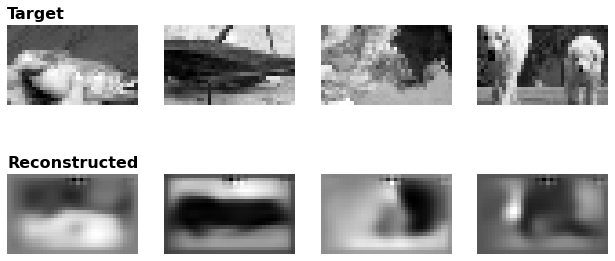

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_20e.png.


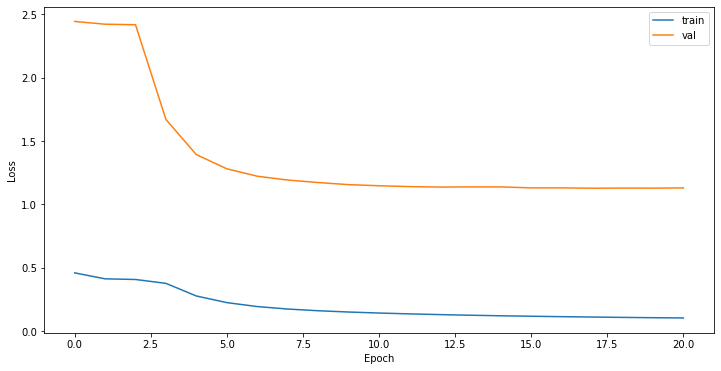

[22/200]
Training progress: [0/6721 (0%)]  Loss: 0.634530
Training progress: [100/6721 (1%)]  Loss: 0.657518
Training progress: [200/6721 (3%)]  Loss: 0.609067
Training progress: [300/6721 (4%)]  Loss: 0.592180
Training progress: [400/6721 (6%)]  Loss: 0.551128
Training progress: [500/6721 (7%)]  Loss: 0.602806
Training progress: [600/6721 (9%)]  Loss: 0.621569
Training progress: [700/6721 (10%)]  Loss: 0.614032
Training progress: [800/6721 (12%)]  Loss: 0.590420
Training progress: [900/6721 (13%)]  Loss: 0.568412
Training progress: [1000/6721 (15%)]  Loss: 0.564768
Training progress: [1100/6721 (16%)]  Loss: 0.618172
train_loss=0.1014, val_losses['total']=1.1307, 21067-10-18: 1.1811, 22846-10-16: 1.1012, 23343-5-17: 1.1610, 23656-14-22: 1.0218, 23964-4-22: 1.1403


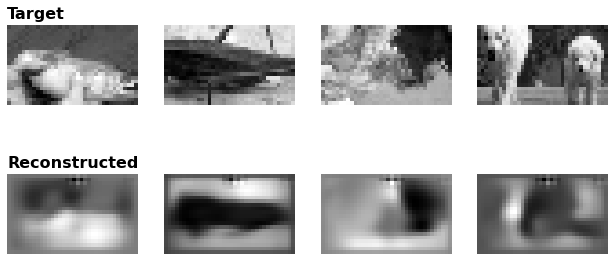

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_21e.png.
[23/200]
Training progress: [0/6721 (0%)]  Loss: 0.613314
Training progress: [100/6721 (1%)]  Loss: 0.647848
Training progress: [200/6721 (3%)]  Loss: 0.604568
Training progress: [300/6721 (4%)]  Loss: 0.575772
Training progress: [400/6721 (6%)]  Loss: 0.538556
Training progress: [500/6721 (7%)]  Loss: 0.591640
Training progress: [600/6721 (9%)]  Loss: 0.608676
Training progress: [700/6721 (10%)]  Loss: 0.600172
Training progress: [800/6721 (12%)]  Loss: 0.576271
Training progress: [900/6721 (13%)]  Loss: 0.551740
Training progress: [1000/6721 (15%)]  Loss: 0.544958
Training progress: [1100/6721 (16%)]  Loss: 0.604879
train_loss=0.0994, val_losses['total']=1.1374, 21067-10-18: 1.1845, 22846-10-16: 1.1044, 23343-5-17: 1.1708, 23656-14-22: 1.0284, 23964-4-22: 1.1516


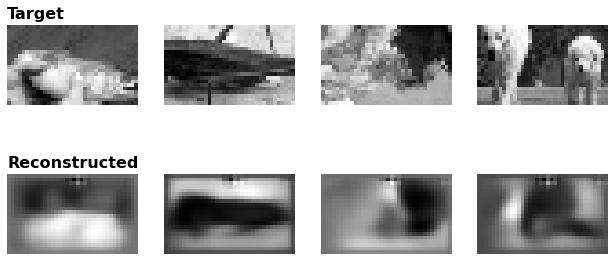

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_22e.png.
[24/200]
Training progress: [0/6721 (0%)]  Loss: 0.611034
Training progress: [100/6721 (1%)]  Loss: 0.636853
Training progress: [200/6721 (3%)]  Loss: 0.590858
Training progress: [300/6721 (4%)]  Loss: 0.557486
Training progress: [400/6721 (6%)]  Loss: 0.532692
Training progress: [500/6721 (7%)]  Loss: 0.582354
Training progress: [600/6721 (9%)]  Loss: 0.579083
Training progress: [700/6721 (10%)]  Loss: 0.584758
Training progress: [800/6721 (12%)]  Loss: 0.569189
Training progress: [900/6721 (13%)]  Loss: 0.544541
Training progress: [1000/6721 (15%)]  Loss: 0.541075
Training progress: [1100/6721 (16%)]  Loss: 0.588661
train_loss=0.0976, val_losses['total']=1.1368, 21067-10-18: 1.1826, 22846-10-16: 1.1055, 23343-5-17: 1.1680, 23656-14-22: 1.0310, 23964-4-22: 1.1503


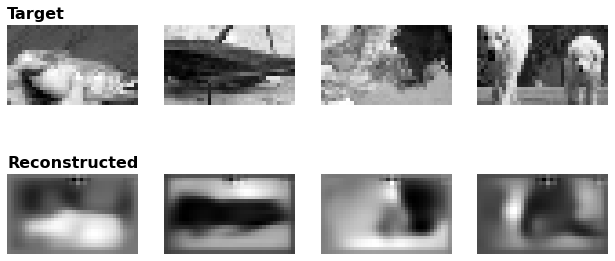

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_23e.png.
[25/200]
Training progress: [0/6721 (0%)]  Loss: 0.606013
Training progress: [100/6721 (1%)]  Loss: 0.624209
Training progress: [200/6721 (3%)]  Loss: 0.581199
Training progress: [300/6721 (4%)]  Loss: 0.555906
Training progress: [400/6721 (6%)]  Loss: 0.527409
Training progress: [500/6721 (7%)]  Loss: 0.569473
Training progress: [600/6721 (9%)]  Loss: 0.575140
Training progress: [700/6721 (10%)]  Loss: 0.582389
Training progress: [800/6721 (12%)]  Loss: 0.563675
Training progress: [900/6721 (13%)]  Loss: 0.540395
Training progress: [1000/6721 (15%)]  Loss: 0.535766
Training progress: [1100/6721 (16%)]  Loss: 0.594064
train_loss=0.0960, val_losses['total']=1.1349, 21067-10-18: 1.1836, 22846-10-16: 1.1046, 23343-5-17: 1.1641, 23656-14-22: 1.0269, 23964-4-22: 1.1482


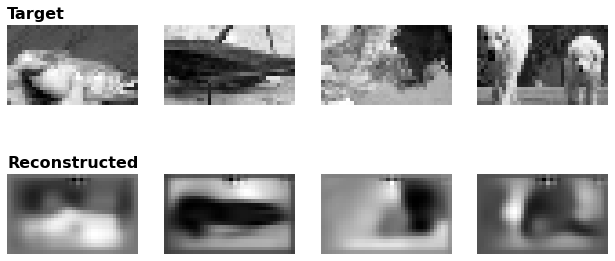

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/samples/stim_comparison_24e.png.
[26/200]
Training progress: [0/6721 (0%)]  Loss: 0.583384
Training progress: [100/6721 (1%)]  Loss: 0.614070
Training progress: [200/6721 (3%)]  Loss: 0.564575
Training progress: [300/6721 (4%)]  Loss: 0.543735
Training progress: [400/6721 (6%)]  Loss: 0.519321
Training progress: [500/6721 (7%)]  Loss: 0.557806
Training progress: [600/6721 (9%)]  Loss: 0.572738
Training progress: [700/6721 (10%)]  Loss: 0.570898


KeyboardInterrupt: 

In [17]:
### train
s, e = len(history["train_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch + 1}/{e}]")

    ### train and val
    dls, neuron_coords = get_mouse_v1_data(config=config)
    if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
        dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"]) # append synthetic data
    if "data_augmentation" in config["data"] and config["data"]["data_augmentation"] is not None:
        dls = append_data_aug_dataloaders(
            dataloaders=dls,
            config=config["data"]["data_augmentation"],
        )
    train_dataloader, val_dataloader = dls["mouse_v1"]["train"], dls["mouse_v1"]["val"]
    train_loss = train(
        model=decoder,
        dataloader=train_dataloader,
        opter=opter,
        loss_fn=loss_fn,
        config=config,
    )
    val_losses = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
        config=config,
    )

    ### save best model
    if val_losses["total"] < best["val_loss"]:
        best["val_loss"] = val_losses["total"]
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_losses["total"])
    if config["wandb"]: wdb_run.log({"train_loss": train_loss, "val_loss": val_losses["total"]}, commit=False)
    print(f"{train_loss=:.4f}, {val_losses['total']=:.4f}", end="")
    for data_key, loss in val_losses.items():
        if data_key != "total":
            print(f", {data_key}: {loss:.4f}", end="")
    print("")

    ### plot reconstructions
    stim_pred = decoder(
        resp[:8].to(config["device"]),
        data_key=sample_data_key,
        neuron_coords=neuron_coords[sample_data_key],
        pupil_center=pupil_center[:8].to(config["device"]),
    ).detach()
    fig = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu(), save_to=make_sample_path(epoch, ""))
    if config["wandb"]: wdb_run.log({"val_stim_reconstruction": fig})

    ### plot losses
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch, save_to=os.path.join(config["dir"], f"losses_{epoch}.png") if config["decoder"]["save_run"] else None)

    ### save ckpt
    if epoch % 5 == 0 and epoch > 0:
        ### ckpt
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "opter": opter.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

Best val loss: 1.1279 at epoch 17
Evaluating on test set with current model...
  Test loss (current model): 1.2189
Evaluating on test set with best model...
  Test loss (best model): 1.2198


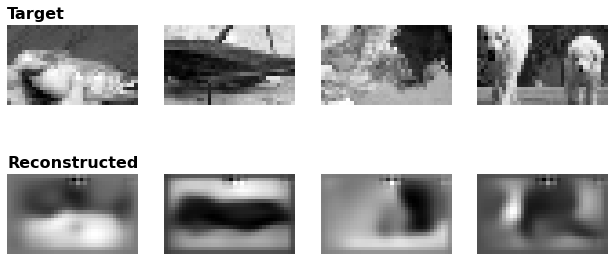

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/stim_comparison_best.png.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_loss,█▇▇▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,17
best_val_loss,1.12789
curr_test_loss,1.21889
final_test_loss,1.21976
train_loss,0.096
val_loss,1.13492


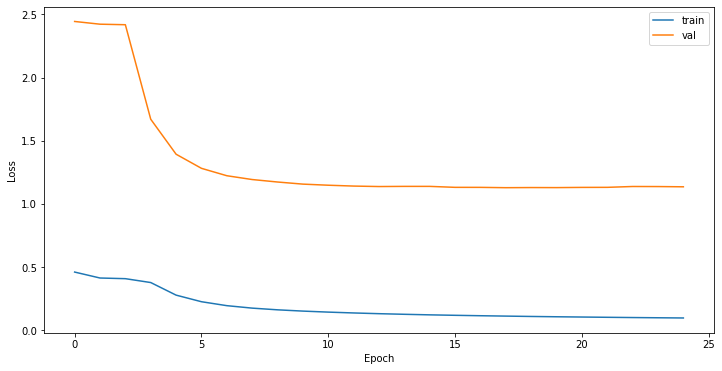

In [22]:
### final evaluation + logging + saving
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "opter": opter.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"), pickle_module=dill)

### eval on test set w/ current params
print("Evaluating on test set with current model...")
dls, neuron_coords = get_mouse_v1_data(config=config)
if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
    dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"])
if "data_augmentation" in config["data"] and config["data"]["data_augmentation"] is not None:
    dls = append_data_aug_dataloaders(
        dataloaders=dls,
        config=config["data"]["data_augmentation"],
    )
test_loss_curr = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn,
    config=config,
)
print(f"  Test loss (current model): {test_loss_curr['total']:.4f}")

### load best model
decoder.load_state_dict(best["model"])

### eval on test set w/ best params
print("Evaluating on test set with best model...")
dls, neuron_coords = get_mouse_v1_data(config=config)
if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
    dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"])
if "data_augmentation" in config["data"] and config["data"]["data_augmentation"] is not None:
    dls = append_data_aug_dataloaders(
        dataloaders=dls,
        config=config["data"]["data_augmentation"],
    )
test_loss_final = val(
    model=decoder,
    dataloader=dls["mouse_v1"]["test"],
    loss_fn=loss_fn,
    config=config,
)
print(f"  Test loss (best model): {test_loss_final['total']:.4f}")

### plot reconstructions of the final model
stim_pred_best = decoder(
    resp.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center.to(config["device"]),
).detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

### log
if config["wandb"]:
    wandb.run.summary["best_val_loss"] = best["val_loss"]
    wandb.run.summary["best_epoch"] = best["epoch"]
    wandb.run.summary["curr_test_loss"] = test_loss_curr["total"]
    wandb.run.summary["final_test_loss"] = test_loss_final["total"]
    wandb.run.summary["best_reconstruction"] = fig

### save/delete wandb run
if config["wandb"]:
    if input("Delete run with 'd', save with anything else: ") == "d":
        print("Deleting wandb run...")
        api = wandb.Api()
        run = api.run(f"johnny1188/{config['wandb']['project']}/{wdb_run.id}")
        run.delete()
    else:
        wdb_run.finish()

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)

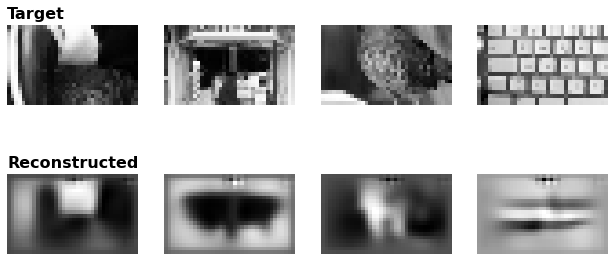

Saved to /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-03_21-37-06/training_stim_comparison_best.png.


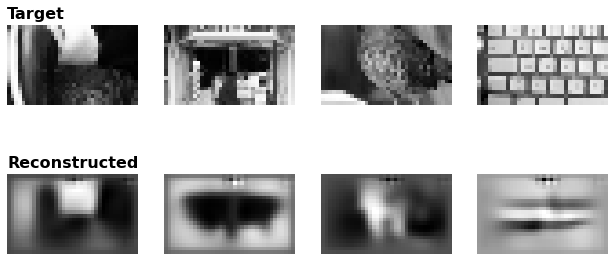

In [23]:
### show training reconstructions
datapoint_training = next(iter(dls["mouse_v1"]["train"].dataloaders[0]))
stim_training, resp_training, pupil_center_training = datapoint_training.images, datapoint_training.responses, datapoint_training.pupil_center
stim_training_pred_best = decoder(
    resp_training.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords[sample_data_key],
    pupil_center=pupil_center_training.to(config["device"]),
).detach().cpu()
plot_comparison(
    target=crop(stim_training[:8], config["crop_win"]).cpu(),
    pred=crop(stim_training_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "training_stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

In [ ]:
l1 = MSELossWithCrop(window=config["crop_win"], standardize=False)
l2 = SSIMLoss(
    window=config["crop_win"],
    log_loss=True,
    inp_normalized=True,
    inp_standardized=False,
)
l = lambda y_hat, y: 0.25 * l1(y_hat, y) + 0.75 * l2(y_hat, y)